**Introduction**: In this approach, we will implement an unsupervised learning strategy to differentiate between GenAI-generated and real images. Unlike supervised models that rely on labeled data, our method will leverage clustering and similarity measures to group similar images without predefined labels.We will be performing below things
1. Cosine Similarity Matrix Clustering
We compute the cosine similarity between image embeddings, to understand the similarity between images.

2. Unsupervised Clustering Algorithm
We will be applying an unsupervised clustering technique, such as K-Means or LHS, to group images with similar embeddings, helping to distinguish patterns in the dataset.
and perform visualization by  t-Distributed Stochastic Neighbor Embedding (t-SNE).
This approach allows us to uncover hidden patterns in the dataset, aiding in the differentiation of GenAI and real images without requiring labeled data.



Mount the Google Drive in a Google Colab environment



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install torch==2.5.0 torchvision ftfy regex tqdm git+https://github.com/openai/CLIP.git

#Read the embeddings dataframe

In [33]:
import pandas as pd
import numpy as np
import torch

def string_to_float_array(s):
    s = s.replace('[', '').replace(']', '')
    return np.array([float(x) for x in s.split(',')])


df = pd.read_csv('drive/MyDrive/colab_notebooks/embeddings.csv')
#del df['Unnamed: 0']
df['embeddings'] = df['embeddings'].apply(string_to_float_array)
df.head()

,embeddings,image_name,label
0,"[0.12522172927856445, 0.17127607762813568, -0....",354503ce71788b2f7725480f7a96123c,0
1,"[0.00956397969275713, -0.024535341188311577, -...",d59817583d8f5081d293afe840ea3da4,1
2,"[-0.014325050637125969, 0.026381907984614372, ...",3d1de42b3f41903ee6f768eb26de95c7,1
3,"[-0.09597162157297134, 0.10650302469730377, -0...",00becac4c25ad5a0c839e1629bedb899,1
4,"[0.368219792842865, 0.17371228337287903, -0.01...",0a5bae79ca67e303fe64e0db70565ed1,1


#K-Means clustering and apply t-SNE for Visualization

Below we will perform the K-Means Clustering and compute the Adjusted Rand Index (ARI) to measure how well K-Means aligns with true labels. After that we can visualize the results using t-SNE. Here instead of labels we will be using K-Means cluster assignments. This will help to understand how well K-Means groups images rather than there natural seperation as previously done.

Adjusted Rand Index (ARI) Score: 0.0132


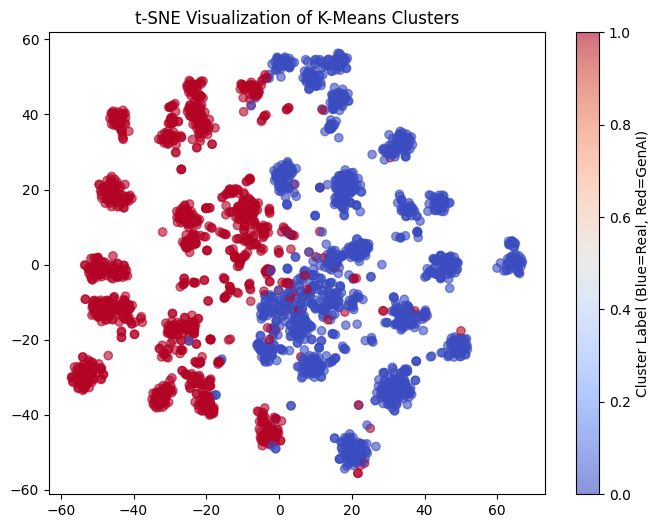

In [27]:
#We will perform below steps to perform our Unsupervised Model training
#1.Train the Model using K-Means
#2. Find the ARI(Adjusted Rand Index) score using our labels.
#3. Perform Visualization t-SNE or PCA or Scatter plot which will help reduce dimensions for visiblity.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

#Convert embeddings from list format to NumPy array
embeddings = np.stack(df['embeddings'].values)

# Extract labels
labels = df['label'].values

# Apply K-Means Clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Compute Adjusted Rand Index (to evaluate clustering)
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI) Score: {ari_score:.4f}")

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Plot t-SNE visualization of clusters
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.6)
plt.title("t-SNE Visualization of K-Means Clusters")
#plt.xlabel("t-SNE Component 1")
#plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster Label (Blue=Real, Red=GenAI)")
plt.show()



The ARI score of 0.0132 suggests that clustering not that great but better than random


Looks like there might be subclusters. Lets analyze by increasing K if it impacts ARI score.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

#Convert embeddings from list format to NumPy array
embeddings = np.stack(df['embeddings'].values)

# Extract labels
labels = df['label'].values

# Apply K-Means Clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Compute Adjusted Rand Index (to evaluate clustering)
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI) Score: {ari_score:.4f}")

Adjusted Rand Index (ARI) Score: 0.0132


I analyzed multiple values for
K= 4  ARI=0.0513,
K=7   ARI=0.0353,
K=10  ARI=0.0332.

#Confusion Matrix for K-Means

[0 0 0 0 0 0 0 0 0 1]
[[1018  728]
 [ 636  706]]


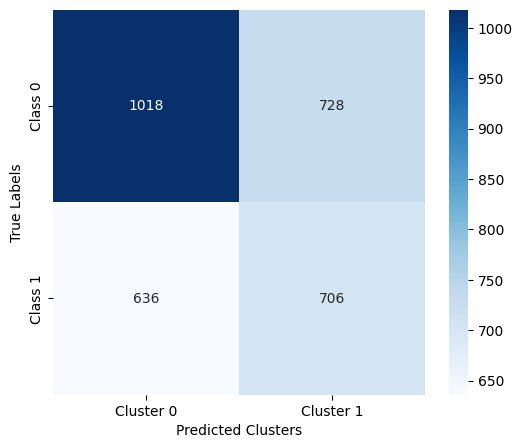

In [35]:
from sklearn.metrics import confusion_matrix

#Find the assigned cluster for each datapoint
cluster_assignments = kmeans.labels_  # Shape: (N,)
print(cluster_assignments[:10])  # First 10 assignments

#Lets compare true labels with the K-Means cluster assignments.
conf_matrix = confusion_matrix(labels, cluster_assignments)
print(conf_matrix)  # 2x2 matrix for K=2


plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cluster 0", "Cluster 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Clusters")
plt.ylabel("True Labels")
#plt.title("Confusion Matrix Heatmap for PCA Analysis")
plt.show()

Summary from above Confusion matrix
1. We are going to retrieve the cliuster assignments after applying the K-Means clustering. First 9 points were assigned to Real (0) and 10th one was assigned to GenAI (1).
2. The confusion matrix will compare the true label with the cluster assignmnets. From the above confusion Matrix, 1018 True images are correct, 728 were misclassified. 636 GenAI images were misclassified, 706 Gen AI images were correctly classified.

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
# What is a centroid Matrix? (2,512) This represents that we have 2 centroids each representing a cluster with 512 dimensional
#features. while the centroid is. the mean mean vector of all the poits(embeddings) in a given cluster. it represents the center
#of the cluster.
centroid_matrix = kmeans.cluster_centers_  # Shape: (K, D)
print(centroid_matrix.shape)  # (2, 512) if K=2 and embeddings are 512-dimensional


#Here we will be calculating the cosine similarity between the centroids, to measure how similar the custer centroids are to
#each other in the embedding space. It wwill measure the angle bewteen two centroid.
similarity_matrix = cosine_similarity(centroid_matrix)
print(similarity_matrix)  # Shape: (K, K)

(2, 512)
[[1.         0.88143581]
 [0.88143581 1.        ]]


Since the cosine similarity between 2 clusters is 0.88 they are not very distinct. The more cosine value closer to 0 more distinct and well sepearted clusters they are.

How can we improve on the K-Means clustering
1. We can normalize the embeddings before clustering.
2. We can also use ELBOW method to find the optimal K.

Overall it appears we will have to be deeper models.

 # Perform K-Means algorithm and visualize using PCA

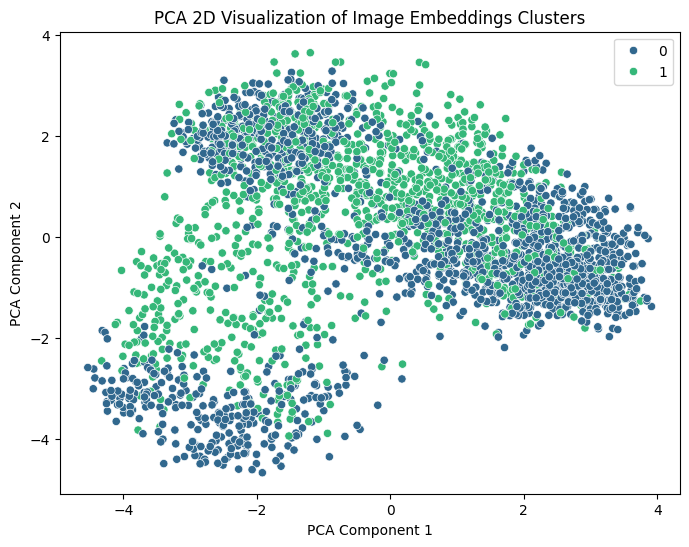

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

#Perform clustering
cluster_size = 2
# Run KMeans with 2 clusters (real vs AI-generated)
kmeans = KMeans(n_clusters=cluster_size, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Plot clusters using PCA for 2D visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1], hue=labels, palette="viridis")
plt.title("PCA 2D Visualization of Image Embeddings Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

Summary from above PCA Graph
1. The PCA component 1 and PCA component 2 are representing the two top principal components from our image embeddings after we apply PCA dimension reduction.
2. Since originally they were 512D now they are reduced to 2D while they are retianinging the most variance from embeddings.
3. There is a clear boundry between clusters which probably represent our two categories or Real and gen AI images.

# Compute Clustering Performance Metrics

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix


# Compute Silhouette Score (only if more than 1 cluster exists)
if len(set(cluster_assignments)) > 1:
    silhouette = silhouette_score(embeddings_2d, cluster_assignments)
else:
    silhouette = None

# Compute ARI (Adjusted Rand Index) - Measures similarity between true labels and clusters
ari = adjusted_rand_score(labels, cluster_assignments)

# Compute NMI (Normalized Mutual Information) - Measures shared information between labels and clusters
nmi = normalized_mutual_info_score(labels, cluster_assignments)

# Print Evaluation Metrics
print(f"Silhouette Score: {silhouette:.4f}" if silhouette is not None else "Silhouette Score: Not applicable (only 1 cluster)")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Silhouette Score: 0.4432
Adjusted Rand Index (ARI): 0.0132
Normalized Mutual Information (NMI): 0.0085


Silhouette Score (0.4432): This is moderate but not very high. A score closer to 1 indicates well-separated clusters, while a score near 0 suggests overlapping clusters.
Adjusted Rand Index (ARI: 0.0132): This is very low, meaning that the clustering solution does not align well with the ground truth labels.
Normalized Mutual Information (NMI: 0.0085): This also suggests very little agreement between the clustering and ground truth.

# Cosine similarity for embeddings

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert embeddings to a numpy array
embeddings = np.array(df['embeddings'].to_list())

# Compute pairwise cosine similarity in one step
cosine_sim_matrix = cosine_similarity(embeddings)

# Print similarity values (if needed)
print(cosine_sim_matrix)


[[1.         0.53280955 0.49867255 ... 0.67975089 0.69353716 0.62649894]
 [0.53280955 1.         0.68945523 ... 0.57821919 0.5572134  0.53999406]
 [0.49867255 0.68945523 1.         ... 0.52249167 0.53043085 0.47858652]
 ...
 [0.67975089 0.57821919 0.52249167 ... 1.         0.79718971 0.81839241]
 [0.69353716 0.5572134  0.53043085 ... 0.79718971 1.         0.76904292]
 [0.62649894 0.53999406 0.47858652 ... 0.81839241 0.76904292 1.        ]]


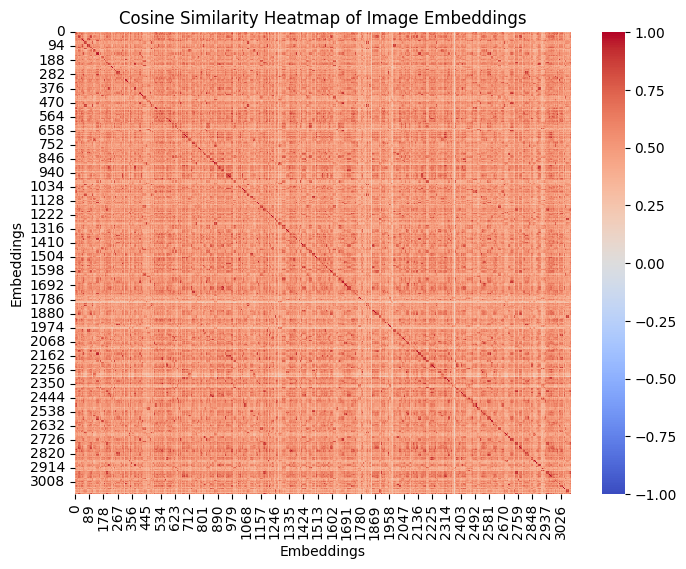

In [42]:
# Plot Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cosine_sim_matrix, cmap="coolwarm", annot=False, vmin=-1, vmax=1)
plt.title("Cosine Similarity Heatmap of Image Embeddings")
plt.xlabel("Embeddings")
plt.ylabel("Embeddings")
plt.show()

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Ensure reproducibility
np.random.seed(42)

# Select a random subset of 100 images
num_images = embeddings.shape[0]  # Total number of embeddings
subset_indices = np.random.choice(num_images, 100, replace=False)
subset_embeddings_100 = embeddings[subset_indices]

# Compute pairwise cosine similarity in one step
cosine_sim_matrix_100 = cosine_similarity(subset_embeddings_100)

# Print similarity values (if needed)
print(cosine_sim_matrix_100)



[[1.         0.38246004 0.38951434 ... 0.33892605 0.47946945 0.43990154]
 [0.38246004 1.         0.40966452 ... 0.39779901 0.37319992 0.35141178]
 [0.38951434 0.40966452 1.         ... 0.48064531 0.54822501 0.47216679]
 ...
 [0.33892605 0.39779901 0.48064531 ... 1.         0.5958658  0.41097649]
 [0.47946945 0.37319992 0.54822501 ... 0.5958658  1.         0.57074508]
 [0.43990154 0.35141178 0.47216679 ... 0.41097649 0.57074508 1.        ]]


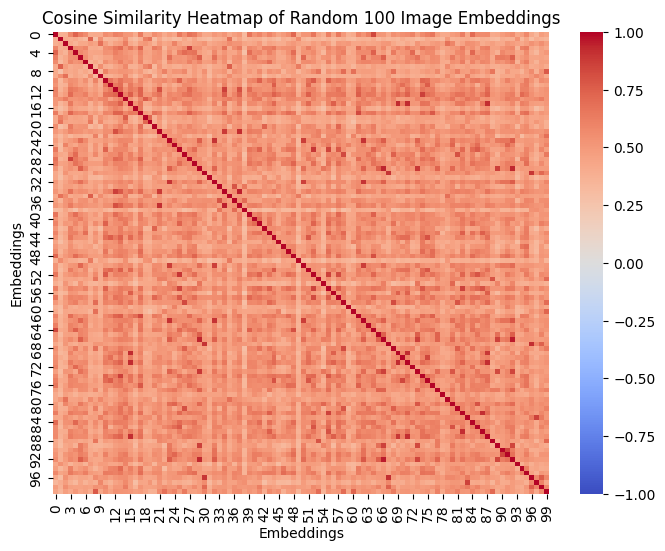

In [50]:
# Plot Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cosine_sim_matrix_100, cmap="coolwarm", annot=False, vmin=-1, vmax=1)
plt.title("Cosine Similarity Heatmap of Random 100 Image Embeddings")
plt.xlabel("Embeddings")
plt.ylabel("Embeddings")
plt.show()

Summary from Heatmap for Cosine Similarity
1. It appears that random images throughout are dark red which suggests high similarity. These might be the closest Gen AI images of Real ones.
2. But most of them are dissimilar.

Summary
From the above K-Means Algorithm and Cosine Similarity Analysis, it looks like unsupervised Model does not work well for our dataset.